In [89]:
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.linear_model import LinearRegression
import pandas as pd
import pickle

In [90]:
cfu_file = '../calibration_data/calibration_02072024/CFU_counts_02072024.xlsx'

df = pd.read_excel(cfu_file)

df['dilution 10^4'] = df['dilution 10^4']*10**4/50
df['dilution 10^5'] = df['dilution 10^5']*10**5/50
df['dilution 10^6'] = df['dilution 10^6']*10**6/50

df['mean'] = df[['dilution 10^4', 'dilution 10^5', 'dilution 10^6']].mean(axis=1)
df['err'] = df[['dilution 10^4', 'dilution 10^5', 'dilution 10^6']].std(axis=1)/np.sqrt(3)

df['dilution'] = 2**(df['col']-1)

In [91]:
od_file = '../calibration_data/calibration_02072024/EK_single_OD600_20240206_134841.xlsx'

p_od = AutoRate.Plate(od_file,mode='single_measurement')
od_data = p_od.od_data_to_dict(p_od.data)

# col 11 is background

rows = ['B','C','D','E','F','G']
cols = ['2','3','4','5','6','7','8','9','10','11']

bg_est = np.mean([od_data[r+'11'] for r in rows])

od_mean = []
od_err = []

for col in cols:
    od_mean.append(np.mean([od_data[r+col] for r in rows]))
    od_err.append(np.std([od_data[r+col] for r in rows])/np.sqrt(len(rows)))

od_mean = od_mean - bg_est

od_mean = np.array(od_mean)
od_err = np.array(od_err)

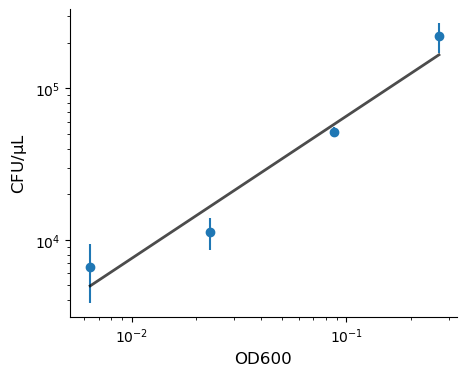

In [92]:
fig,ax = plt.subplots(figsize=(5,4))

sample_cols = df['col'].values

ax.errorbar(od_mean[sample_cols-2],df['mean'],yerr=df['err'],xerr=od_err[sample_cols-2],fmt='o',label='CFU')

ax.set_yscale('log')
ax.set_xscale('log')

# weighted linear regression

x = np.log10(od_mean[sample_cols-2])
y = np.log10(df['mean'])
yerr = np.log10(df['err'])

reg = LinearRegression().fit(x.reshape(-1,1),y,sample_weight=1/yerr)

# plot fit

x_fit = np.linspace(np.min(x),np.max(x),100)
y_fit = reg.predict(x_fit.reshape(-1,1))

ax.plot(10**x_fit,10**y_fit,'k',label='fit',alpha=0.7,linewidth=2)

ax.set_xlabel('OD600',fontsize=12)

ax.set_ylabel('CFU/$\mathrm{\mu}$L',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [93]:
ab_file = '../calibration_data/calibration_02072024/EK_single_AB_constant_gain_20240206_144008.xlsx'

p_ab = AutoRate.Plate(ab_file,mode='single_measurement')
ab_data = p_ab.od_data_to_dict(p_ab.data)

ab_background = np.mean([ab_data[r+'11'] for r in rows])

rows = ['C','D','E','F','G']

ab_mean = []
ab_err = []

for col in cols:
    ab_mean.append(np.mean([ab_data[r+col] for r in rows]))
    ab_err.append(np.std([ab_data[r+col] for r in rows])/np.sqrt(len(rows)))

ab_mean = np.array(ab_mean) - ab_background

ab_mean = np.array(ab_mean)
ab_err = np.array(ab_err)

In [98]:
ab_background

197.33333333333334

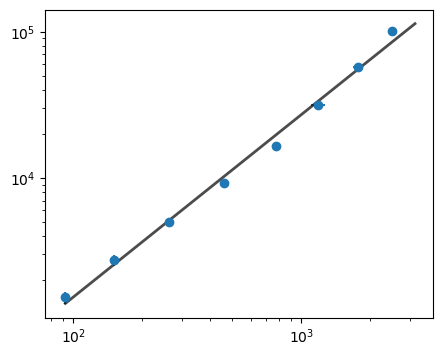

In [94]:
# convert OD estimates to CFU

od_t = np.log10(od_mean[0:-1])
cell_count_est = 10**reg.predict(od_t.reshape(-1,1))
cell_count_est_err = cell_count_est*np.log(10)*od_err[0:-1]/od_mean[0:-1]

fig,ax = plt.subplots(figsize=(5,4))

ax.errorbar(ab_mean[1:-1],cell_count_est[1:],yerr=cell_count_est_err[1:],xerr=ab_err[1:-1],fmt='o',label='AB')

ax.set_yscale('log')
ax.set_xscale('log')

# weighted linear regression

x = np.log10(ab_mean[1:-1])
y = np.log10(cell_count_est[1:])
w = 1/cell_count_est_err[1:]

reg = LinearRegression().fit(x.reshape(-1,1),y)

# plot fit

x_fit = np.linspace(np.min(x),np.max(x)+0.1,100)
y_fit = reg.predict(x_fit.reshape(-1,1))

ax.plot(10**x_fit,10**y_fit,'k',label='fit',alpha=0.7,linewidth=2)

In [95]:
# pickle the fit

with open('calibration_02072024.pkl','wb') as f:
    pickle.dump(reg,f)

In [100]:
10**x

array([2506.86666667, 1773.26666667, 1187.46666667,  777.26666667,
        459.26666667,  263.26666667,  151.66666667,   92.46666667])